### Project Description

Generation of circuit diagrams represented both as hand-drawn images and as abstracted graph structures.
The experiments will be based on a data set of annotated images, which should to be
extended as a warm-up task by the participating students.
The main task consists of training different neural network architectures (deep autoencoders,
generative adversarial networks, graph auto-encoders) to encode both graph
structures and images for further generation purposes:

1. In a first experiment, graphs and images are trained independently.
2. In a second experiment, both representations are joined in a common coding space. The results are compared to with the first experiment.
3. Finally, the generators of the preceding experiments are utilized for the generation of new circuits
4. (Optionally) GANs are trained and their outputs are compared to the previous
results

### Task: 
1. Create a simple, fully-connected autoencoder with 2 hidden layers and a latent space size of 10. 
2. Train it on the mnist database using the mean-squared error and only basic pytorch functions. Rather than training the identity function, the input should be an mnist sample and the output should be an printed text image generated from the coresponding ground truth. 
3. After each epoch, plot the error on both the train and test set. 
4. Create an account on https://git.opendfki.de/ in order to share your download and training code with the topic provider.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Load training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Creating dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualizing a sample Image from dataset

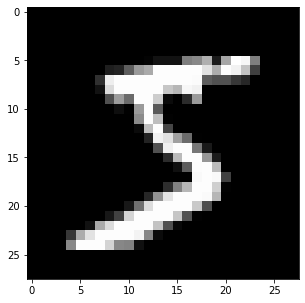

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Creating and Initializing a model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder - 784 -> 900 -> 10
        self.fc1 = nn.Linear(28 * 28, 30*30)
        self.fc2 = nn.Linear(30*30, encoding_dim)
        
        ## decode - 10 -> 900 -> 784
        self.fc3 = nn.Linear(encoding_dim, 30*30)
        self.fc4 = nn.Linear(30*30, 28*28)
        

    def forward(self, x):
        # Layer with relu activation functions
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

encoding_dim = 10
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=900, bias=True)
  (fc2): Linear(in_features=900, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=900, bias=True)
  (fc4): Linear(in_features=900, out_features=784, bias=True)
)


### Configure model using Mean Square Error and Adam Optimizer

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Taining model and plotting the error for train and test dataset after each epoch

Epoch: 1 	Training Loss: 0.529987 	 Test Loss: 0.428724
Epoch: 2 	Training Loss: 0.399769 	 Test Loss: 0.382679
Epoch: 3 	Training Loss: 0.370319 	 Test Loss: 0.360023
Epoch: 4 	Training Loss: 0.353581 	 Test Loss: 0.346789
Epoch: 5 	Training Loss: 0.342206 	 Test Loss: 0.336908
Epoch: 6 	Training Loss: 0.334205 	 Test Loss: 0.330420
Epoch: 7 	Training Loss: 0.327959 	 Test Loss: 0.325051
Epoch: 8 	Training Loss: 0.323063 	 Test Loss: 0.320159
Epoch: 9 	Training Loss: 0.319144 	 Test Loss: 0.316832
Epoch: 10 	Training Loss: 0.315836 	 Test Loss: 0.313545


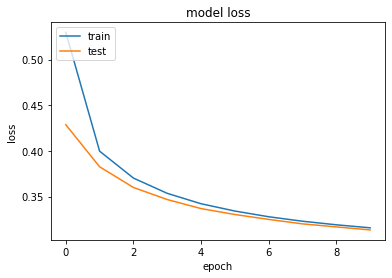

In [6]:
# number of epochs to train the model
n_epochs = 10
trainh_loss=[]
testh_loss=[]

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    test_loss = 0.0

## Training and Checking error in train set.
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

## Training and Checking error in test set.
## Below steps are same as above steps done for train set.
    for data in test_loader:
        images, _ = data
        images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        test_loss += loss.item()*images.size(0)

    # Average training score
    train_loss = train_loss/len(train_loader)
    test_loss = test_loss/len(test_loader)
    
    trainh_loss.append(train_loss) 
    testh_loss.append(test_loss) 
    
    print('Epoch: {} \tTraining Loss: {:.6f} \t Test Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        test_loss
        ))

plt.plot(np.array(trainh_loss))
plt.plot(np.array(testh_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Visualizing the result of the above autoencoder

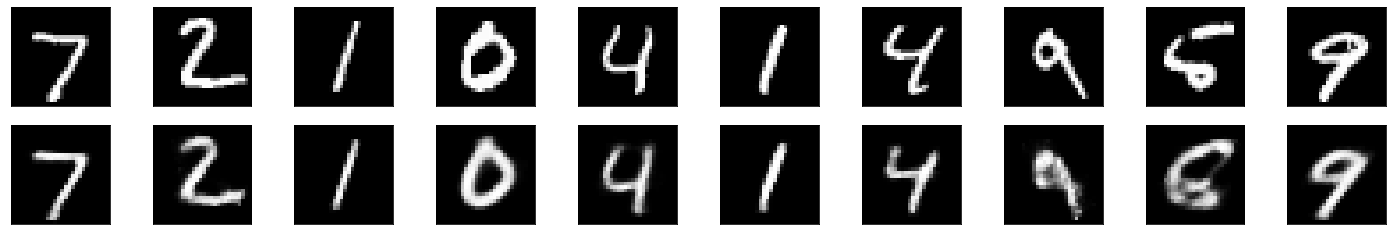

In [7]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)